<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Lab: Develop GANs Using Keras**


Estimated time needed: **30** minutes


In this lab, you will gain practical experience in developing generative adversarial networks (GANs) using Keras. You will learn to preprocess data, construct the generator and discriminator models, combine them to create the GAN, train the GAN, and evaluate its performance. GANs are powerful tools for generating synthetic data, and this lab provides a solid foundation for further exploration and experimentation with more advanced GAN architectures and applications.


## Objectives

After completing this lab, you will be able to: 
- Build, train, and evaluate GANs using Keras 
- Explore GAN architectures, data preprocessing, model training, and performance evaluation 


----


## Step-by-step instructions 

### Step 1: Data preprocessing 

#### Objective: 
- Load and preprocess the MNIST dataset for training a GAN. 

#### Instructions: 
1. Load the MNIST dataset: 
   - Use Keras to load the MNIST dataset.
   - Normalize the image pixel values to the range [-1, 1].

2. Reshape the data:
   - Expand the dimensions of the images to match the input shape required by the GAN (28×28×1).


In [1]:
%%capture
!pip install tensorflow-cpu==2.16.2

# Suppress warnings and set environment variables
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'




In [2]:
import numpy as np
from tensorflow.keras.datasets import mnist
import warnings

# Suppress all Python warnings
warnings.filterwarnings('ignore')

# Load the MNIST dataset
(x_train, _), (_, _) = mnist.load_data()

# Normalize the pixel values to the range [-1, 1]
x_train = x_train.astype('float32') / 127.5 - 1.
x_train = np.expand_dims(x_train, axis=-1)

# Print the shape of the data
print(x_train.shape)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
(60000, 28, 28, 1)


#### Explanation: 

This step prepares the MNIST dataset for training by normalizing the pixel values to the range [-1, 1] and reshaping the images to have a single color channel. Normalization helps in faster convergence during training, and reshaping is required because the input layer of our GAN expects a three-dimensional tensor. 


### Step 2: Building the generator model 

#### Objective: 
- Construct the generator model for the GAN using the Keras functional API. 

#### Instructions: 
1. Define the generator. 
   - Create a Sequential model. 
   - Add Dense, LeakyReLU, BatchNormalization, and Reshape layers to build the generator.


In [3]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape 

# Define the generator model 
def build_generator(): 
    model = Sequential() 
    model.add(Dense(256, input_dim=100)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(Dense(512)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(Dense(1024)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(Dense(28 * 28 * 1, activation='tanh')) 
    model.add(Reshape((28, 28, 1))) 
    return model 

# Build the generator 
generator = build_generator() 
generator.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 784)            │       803,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,493,520 (5.70 MB)

 Trainable params: 1,489,936 (5.68 MB)

 Non-trainable params: 3,584 (14.00 KB)

#### Explanation: 

This step involves building the generator model for the GAN. The generator takes a random noise vector as an input and generates a synthetic image. The model uses Dense, LeakyReLU, BatchNormalization, and Reshape layers to achieve this. 


### Step 3: Building the discriminator model 

#### Objective: 
- Construct the discriminator model for the GAN using the Keras functional API. 

#### Instructions: 
1. Define the discriminator. 
   - Create a Sequential model. 
   - Add Flatten, Dense, and LeakyReLU layers to build the discriminator. 

2. Compile the discriminator. 
   - Compile the model using binary cross-entropy loss and the Adam optimizer. 


In [4]:
from tensorflow.keras.layers import Flatten 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LeakyReLU

# Define the discriminator model 
def build_discriminator(): 
    model = Sequential() 
    model.add(Flatten(input_shape=(28, 28, 1))) 
    model.add(Dense(512)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(Dense(256)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(Dense(1, activation='sigmoid')) 
    return model 

# Build and compile the discriminator 
discriminator = build_discriminator() 
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
discriminator.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,505 (2.04 MB)

 Trainable params: 533,505 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

#### Explanation: 

This exercise involves building the discriminator model for the GAN. The discriminator takes an image as an input and outputs a probability indicating whether the image is real or fake. The model uses Flatten, Dense, and LeakyReLU layers to achieve this. 


### Step 4: Building the GAN Model 

#### Objective: 
- Combine the generator and discriminator to create the GAN model using the Keras functional API. 

#### Instructions: 
1. Define the GAN. 
   - Create an input layer for the noise vector. 
   - Pass the noise vector through the generator to produce a synthetic image. 
   - Pass the synthetic image through the discriminator to get the classification. 
   - Compile the GAN using binary cross-entropy loss and the Adam optimizer. 


In [5]:
from tensorflow.keras.layers import Input 
from tensorflow.keras.models import Model 

# Create the GAN by stacking the generator and the discriminator 
def build_gan(generator, discriminator): 
    discriminator.trainable = False 
    gan_input = Input(shape=(100,)) 
    generated_image = generator(gan_input) 
    gan_output = discriminator(generated_image) 
    gan = Model(gan_input, gan_output) 
    gan.compile(loss='binary_crossentropy', optimizer='adam') 
    return gan 

# Build the GAN 
gan = build_gan(generator, discriminator) 
gan.summary()


# Sync discriminator weights from trainable to non-trainable in GAN
gan.layers[2].set_weights(discriminator.get_weights())



Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 28, 28, 1)      │     1,493,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 1)              │       533,505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,027,025 (7.73 MB)

 Trainable params: 1,489,936 (5.68 MB)

 Non-trainable params: 537,089 (2.05 MB)

#### Explanation: 

This step involves combining the generator and discriminator models to create the GAN. The GAN takes a noise vector as an input, generates a synthetic image using the generator, and classifies the image using the discriminator. The discriminator is set to non-trainable when compiling the GAN to ensure that only the generator is updated during the adversarial training. 


### Step 5: Training the GAN 

#### Objective: 
- Train the GAN on the MNIST dataset. 

#### Instructions: 
1. Define training parameters. 
   - Set the batch size, number of epochs, and sample interval. 
 
2. Train the discriminator. 
   - Sample a batch of real images from the dataset. 
   - Generate a batch of synthetic images from the generator. 
   - Train the discriminator on both real and generated images. 
 
3. Train the generator. 
   - Generate a batch of noise vectors. 
   - Train the GAN to improve the generator’s ability to fool the discriminator. 
 
4. Print the progress: 
   - Print the discriminator and generator losses at regular intervals.


In [6]:
# Define and compile the discriminator model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Flatten

def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28, 1)))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Build and recompile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
discriminator.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,505 (2.04 MB)

 Trainable params: 533,505 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Training parameters 

batch_size = 64 
epochs = 200
sample_interval = 10

# Adversarial ground truths 
real = np.ones((batch_size, 1)) 
fake = np.zeros((batch_size, 1)) 

# Training loop 
for epoch in range(epochs): 
    # Train the discriminator 
    idx = np.random.randint(0, x_train.shape[0], batch_size) 
    real_images = x_train[idx] 
    noise = np.random.normal(0, 1, (batch_size, 100)) 
    generated_images = generator.predict(noise) 
    d_loss_real = discriminator.train_on_batch(real_images, real) 
    d_loss_fake = discriminator.train_on_batch(generated_images, fake) 
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 

    # Train the generator 
    noise = np.random.normal(0, 1, (batch_size, 100)) 
    g_loss = gan.train_on_batch(noise, real) 

    # Print the progress 
    if epoch % sample_interval == 0: 
        print(f"{epoch} [D loss: {d_loss[0]}] [D accuracy: {100 * d_loss[1]}%] [G loss: {g_loss}]")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step 
0 [D loss: 0.6039193868637085] [D accuracy: 83.203125%] [G loss: 0.6160345673561096]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
10 [D loss: 0.14517700672149658] [D accuracy: 96.6551661491394%] [G loss: 0.21317841112613678]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
20 [D loss: 0.0755707

#### Explanation: 

This step involves training the GAN on the MNIST dataset. The training loop alternates between training the discriminator and the generator. The discriminator is trained on batches of real and generated images, whereas the generator is trained to improve its ability to fool the discriminator. The progress is printed at regular intervals to monitor the training process. 


### Step 6: Assessing the Quality of Generated Images 

### Objective: 
- Evaluate the performance of the trained GAN. 

### Evaluating the GAN

After training the GAN, we need to assess the quality of the synthetic images generated by the generator. There are two main ways to evaluate the performance of GANs: qualitative assessment and quantitative assessment.

### Qualitative Assessment: Visual Inspection

Visual inspection is a straightforward method to assess the quality of images generated by a GAN. You can use the `sample_images` function provided in the lab to visualize a grid of generated images. During visual inspection, look for the following qualities:

- **Clarity**: The images should be sharp and not blurry. Blurry images indicate that the generator is struggling to learn the patterns in the data.
- **Coherence**: The generated images should have a coherent structure that resembles the original images in the dataset. For example, in the case of MNIST, the generated images should resemble handwritten digits with the correct number of strokes and shapes.
- **Diversity**: There should be a variety of images generated by the GAN. If all images look similar, it might indicate that the generator is overfitting or has collapsed to a single mode.

#### Instructions:

1. Run the `sample_images` function after training the GAN to display a grid of generated images.
2. Inspect the images for clarity, coherence, and diversity.



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 148.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 143.3 MB/s eta 0:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


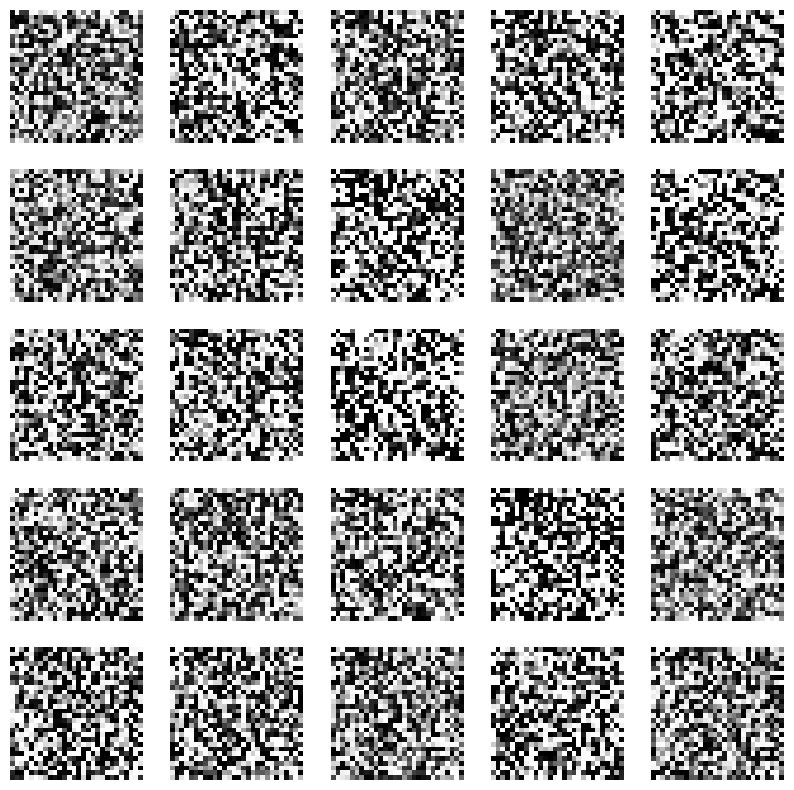

In [8]:
!pip install matplotlib
import matplotlib.pyplot as plt 

def sample_images(generator, epoch, num_images=25): 
    noise = np.random.normal(0, 1, (num_images, 100)) 
    generated_images = generator.predict(noise) 
    generated_images = 0.5 * generated_images + 0.5  # Rescale to [0, 1] 
    fig, axs = plt.subplots(5, 5, figsize=(10, 10)) 
    count = 0 

    for i in range(5): 
        for j in range(5): 
            axs[i, j].imshow(generated_images[count, :, :, 0], cmap='gray') 
            axs[i, j].axis('off') 
            count += 1 
    plt.show() 

# Sample images at the end of training 
sample_images(generator, epochs)


By using visual inspection, you can quickly identify any issues with the generated images. If you notice blurriness, lack of structure, or lack of diversity, consider adjusting the model architecture or training parameters.

### 2. Quantitative Assessment: Metrics

While visual inspection provides an intuitive understanding of the GAN’s performance, it can be subjective. To objectively evaluate GAN performance, you can use quantitative metrics such as:

- **Inception Score (IS)**: This score measures both the quality and diversity of generated images by using a pre-trained classifier (such as Inception-v3) to predict the class of each image. A higher score indicates that the images are both high-quality and diverse. However, IS is not very effective for simple datasets like MNIST; it’s more suitable for complex datasets.

- **Fréchet Inception Distance (FID)**: This metric calculates the distance between the distributions of generated images and real images. A lower FID score indicates that the generated images are more similar to real images. FID is commonly used and considered a reliable metric for evaluating GAN performance.

- **Discriminator Accuracy**: During training, if the discriminator's accuracy is around 50%, it suggests that the generator is producing realistic images that are hard to distinguish from real ones. This metric is easy to implement and provides quick feedback on the training progress.

### Instructions:

You can use the provided code snippet to calculate the discriminator's accuracy on both real and fake images.


In [9]:
# Calculate and print the discriminator accuracy on real vs. fake images
noise = np.random.normal(0, 1, (batch_size, 100))
generated_images = generator.predict(noise)

# Evaluate the discriminator on real images
real_images = x_train[np.random.randint(0, x_train.shape[0], batch_size)]
d_loss_real = discriminator.evaluate(real_images, np.ones((batch_size, 1)), verbose=0)

# Evaluate the discriminator on fake images
d_loss_fake = discriminator.evaluate(generated_images, np.zeros((batch_size, 1)), verbose=0)

print(f"Discriminator Accuracy on Real Images: {d_loss_real[1] * 100:.2f}%")
print(f"Discriminator Accuracy on Fake Images: {d_loss_fake[1] * 100:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Discriminator Accuracy on Real Images: 100.00%
Discriminator Accuracy on Fake Images: 100.00%


If the discriminator’s accuracy is around 50%, it implies the generator has learned to produce realistic images. Higher or lower accuracy may suggest that either the generator is not producing convincing images, or the discriminator is overfitting.

### 3. Combining Qualitative and Quantitative Assessments

For a comprehensive evaluation of the GAN:

1. **Start with visual inspection** to get a quick sense of image quality. If the images look blurry or too similar, it might indicate problems with the training process.

2. **Use quantitative metrics** like FID or discriminator accuracy to provide objective evidence of the GAN’s performance.

3. **Monitor training progress** by visualizing the generator and discriminator losses over time. This helps in understanding if the GAN is suffering from instability or if one model is overpowering the other.


#### Explanation: 

By combining qualitative inspection and quantitative metrics, you can effectively assess the quality of images generated by GANs. This dual approach provides a more robust evaluation, ensuring that the generated data is not only visually plausible but also statistically similar to the real data. Experiment with different architectures, learning rates, and training parameters to improve the GAN’s performance further.


# Exercises

### Exercise 1: Modify the generator’s architecture 

#### Objective: 
- Experiment with adding more layers to the generator to understand how the depth of the network impacts the quality of generated images. 

#### Instructions: 
1. Add one more Dense layer with 2048 units to the generator model. 
2. Rebuild the generator and print the summary. 


In [11]:
def build_generator(): 
    model = Sequential() 
    model.add(Dense(256, input_dim=100)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(Dense(512)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(Dense(1024)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(Dense(2048)) #
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(Dense(28 * 28 * 1, activation='tanh')) 
    model.add(Reshape((28, 28, 1))) 
    return model 

# Rebuild the generator 
generator = build_generator() 
generator.summary() 

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 2048)           │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 784)            │     1,606,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,403,728 (16.80 MB)

 Trainable params: 4,396,048 (16.77 MB)

 Non-trainable params: 7,680 (30.00 KB)

<details>
    <summary>Click here for Solution</summary>

```python
# Modify the generator model by adding an additional Dense layer 

def build_generator(): 
    model = Sequential() 
    model.add(Dense(256, input_dim=100)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(Dense(512)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(Dense(1024)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(Dense(2048))  # New layer added 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(Dense(28 * 28 * 1, activation='tanh')) 
    model.add(Reshape((28, 28, 1))) 
    return model 

# Rebuild the generator 
generator = build_generator() 
generator.summary() 
```

</details>


### Exercise 2 - Adjust the discriminator’s learning rate 

#### Objective: 
- Explore how changing the learning rate of the discriminator’s optimizer affects training stability and model performance. 

#### Instructions: 
1. Change the learning rate of the Adam optimizer for the discriminator to 0.0002. 
2. Rebuild and compile the discriminator with the new learning rate. 


In [12]:
import tensorflow as tf
def build_discriminator(): 
    model = Sequential() 
    model.add(Flatten(input_shape=(28, 28, 1))) 
    model.add(Dense(512)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(Dense(256)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(Dense(1, activation='sigmoid')) 
    return model 

# Rebuild and compile the discriminator with a lower learning rate 
discriminator = build_discriminator() 
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), 
                      metrics=['accuracy']) 

discriminator.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,505 (2.04 MB)

 Trainable params: 533,505 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

<details>
    <summary>Click here for Solution</summary>

```python
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LeakyReLU

def build_discriminator(): 
    model = Sequential() 
    model.add(Flatten(input_shape=(28, 28, 1))) 
    model.add(Dense(512)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(Dense(256)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(Dense(1, activation='sigmoid')) 
    return model 

# Rebuild and compile the discriminator with a lower learning rate 
discriminator = build_discriminator() 
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), 
                      metrics=['accuracy']) 

discriminator.summary()

```

</details>


### Exercise 3 - Visualize training progress 

#### Objective: 
- Visualize the loss of the discriminator and generator during training to monitor the training process.  

#### Instructions: 
1. Modify the training loop to store the discriminator and generator losses. 
2. Plot the losses after training to visualize the training progress. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step 
0 [D loss: 1.1874282360076904] [D accuracy: 17.578125] [G loss: 0.01465101819485426]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
10 [D loss: 0.3042505383491516] [D accuracy: 92.94676780700684] [G loss: 0.013996637426316738]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
20 [D loss: 0.1880595

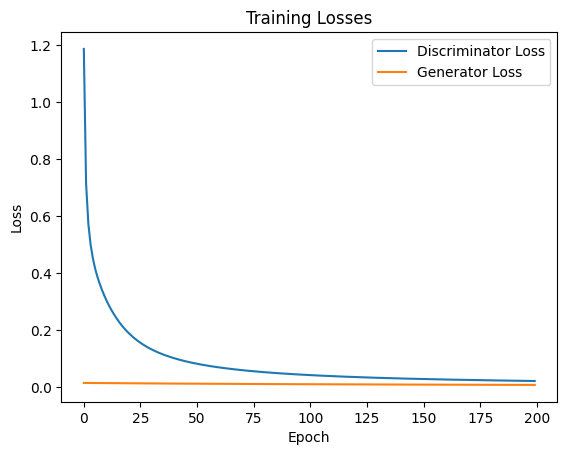

In [13]:
# Initialize lists to store losses 
d = [] 
g = [] 

 
# Training loop with loss storage 
for epoch in range(epochs): 
    idx = np.random.randint(0, x_train.shape[0], batch_size) 
    real_images = x_train[idx] 
    noise = np.random.normal(0, 1, (batch_size, 100)) 
    generated_images = generator.predict(noise) 
    d_loss_real = discriminator.train_on_batch(real_images, real) 
    d_loss_fake = discriminator.train_on_batch(generated_images, fake) 
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 
    d.append(d_loss[0]) 
  

    noise = np.random.normal(0, 1, (batch_size, 100)) 
    g_loss = gan.train_on_batch(noise, real) 
    g.append(g_loss) 

  
    if epoch % sample_interval == 0: 
        print(f"{epoch} [D loss: {d_loss[0]}] [D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]") 
  
# Plot the training losses 
plt.plot(d, label='Discriminator Loss') 
plt.plot(g, label='Generator Loss') 
plt.xlabel('Epoch') 
plt.ylabel('Loss') 
plt.title('Training Losses') 
plt.legend() 
plt.show() 


<details>
    <summary>Click here for Solution</summary>

```python
# Initialize lists to store losses 
d_losses = [] 
g_losses = [] 

 
# Training loop with loss storage 
for epoch in range(epochs): 
    idx = np.random.randint(0, x_train.shape[0], batch_size) 
    real_images = x_train[idx] 
    noise = np.random.normal(0, 1, (batch_size, 100)) 
    generated_images = generator.predict(noise) 
    d_loss_real = discriminator.train_on_batch(real_images, real) 
    d_loss_fake = discriminator.train_on_batch(generated_images, fake) 
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 
    d_losses.append(d_loss[0]) 
  

    noise = np.random.normal(0, 1, (batch_size, 100)) 
    g_loss = gan.train_on_batch(noise, real) 
    g_losses.append(g_loss) 

  
    if epoch % sample_interval == 0: 
        print(f"{epoch} [D loss: {d_loss[0]}] [D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]") 
  
# Plot the training losses 
plt.figure(figsize=(10, 5)) 
plt.plot(d_losses, label='Discriminator Loss') 
plt.plot(g_losses, label='Generator Loss') 
plt.xlabel('Epoch') 
plt.ylabel('Loss') 
plt.title('Training Losses') 
plt.legend() 
plt.show() 
```

</details>


### Summary 
By completing these exercises, students will:  
1. Understand the impact of adding more layers to the generator on the quality of generated images. 
2. Learn how adjusting the learning rate of the discriminator’s optimizer can affect training stability and performance. 
3. Visualize the training progress by plotting the losses of the discriminator and generator. 


### Conclusion: 

In this lab, you have gained practical experience in developing GANs using Keras. By completing these exercises, you have developed a strong understanding of the key concepts and techniques involved in working with GANs. Continue experimenting with different architectures, datasets, and training strategies to deepen your knowledge and skills in this exciting area of machine learning. Thank you for participating in this lab, and happy coding! 


Copyright © IBM Corporation. All rights reserved.
